# Pairs Trading with Kalman Filter
This notebook implements a pairs trading strategy using a Kalman filter for parameter estimation, based on "Pairs Trading with R" by Dainel Palomar

In [13]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import talib as ta
import yfinance as yf
import statsmodels.formula.api as smf
from pykalman import KalmanFilter
import matplotlib.pyplot as plt
import math

## Load Data
We'll use EWH (Hong Kong ETF) and EWZ (Brazil ETF) as our pair.

In [14]:
tickers = ['EWH', 'EWZ']
start_date = '2000-08-01'
end_date = '2004-1-1'

# Download closing prices and set frequency to business days
dfc = yf.download(tickers, start=start_date, end=end_date, auto_adjust=True, multi_level_index=False).Close
dfc = dfc.asfreq('B').fillna(method='ffill')
dfc.info()

[*********************100%***********************]  2 of 2 completed

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 892 entries, 2000-08-01 to 2003-12-31
Freq: B
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   EWH     892 non-null    float64
 1   EWZ     892 non-null    float64
dtypes: float64(2)
memory usage: 20.9 KB



/var/folders/hk/45k_bv011_9gfmq965823cm00000gn/T/ipykernel_41129/392444795.py:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  dfc = dfc.asfreq('B').fillna(method='ffill')


## Strategy Functions
Define the core functions for the pairs trading strategy.

In [15]:
def compute_spread(Y, gamma, mu, name=np.NaN):
    """Compute the spread between two assets using estimated parameters.
    
    Args:
        Y: DataFrame with price series
        gamma: Hedge ratio
        mu: Mean level of spread
        name: Optional name for the spread series
    
    Returns:
        pd.Series: Calculated spread
    """
    w1 = pd.DataFrame({'x1': 1, 'gamma': -gamma})
    w2 = pd.DataFrame({'x1': 1+gamma, 'gamma': 1+gamma})
    w_spread = w1/w2
    spread = (Y * w_spread).sum() - mu/(1+gamma)
    return spread

def generate_Z_score_EMA(spread, n=120):
    """Generate Z-scores using exponential moving average.
    
    Args:
        spread: Series of spread values
        n: Lookback period for EMA calculation
    
    Returns:
        pd.Series: Z-scores
    """
    # Calculate mean using EMA
    spread_mean = ta.EMA(spread, n)
    spread_mean = spread_mean.bfill()

    # Calculate demeaned spread
    spread_demeaned = spread - spread_mean

    # Calculate variance using EMA of squared deviations
    spread_var = ta.EMA(spread_demeaned**2, n)
    spread_var = spread_var.bfill()

    # Calculate Z-score
    Zscore = spread_demeaned / np.sqrt(spread_var)
    return Zscore

def estimate_mu_gamma_LS(Y):
    """Estimate initial parameters using least squares regression.
    
    Args:
        Y: DataFrame with price series
    
    Returns:
        tuple: (mu, gamma) estimated parameters
    """
    trainLen = round(0.3 * len(Y))
    rLP = Y[0:trainLen]
    t1, t2 = Y.columns.values
    f = t1 + "~" + t2

    model = smf.ols(formula=f, data=rLP).fit()
    mu, gamma = model.params
    return mu, gamma

def generate_signal(Z_score, threshold_long, threshold_short):
    """Generate trading signals based on Z-score thresholds.
    
    Args:
        Z_score: Series of Z-scores
        threshold_long: Lower threshold for long positions
        threshold_short: Upper threshold for short positions
    
    Returns:
        pd.Series: Trading signals (-1, 0, 1)
    """
    signal = pd.Series(index=Z_score.index)

    # Set initial position
    signal.iloc[0] = 0
    if Z_score.iloc[0] <= threshold_long.iloc[0]:
        signal.iloc[0] = 1
    elif Z_score.iloc[0] >= threshold_short.iloc[0]:
        signal.iloc[0] = -1

    # Generate signals for remaining periods
    for t in range(1, len(Z_score)):
        if signal.iloc[t-1] == 0:  # no position
            if Z_score.iloc[t] <= threshold_long.iloc[t]:
                signal.iloc[t] = 1
            elif Z_score.iloc[t] >= threshold_short.iloc[t]:
                signal.iloc[t] = -1
            else:
                signal.iloc[t] = 0
        elif signal.iloc[t-1] == 1:  # long position
            if Z_score.iloc[t] >= 0:
                signal.iloc[t] = 0
            else:
                signal.iloc[t] = signal.iloc[t-1]
        else:  # short position
            if Z_score.iloc[t] <= 0:
                signal.iloc[t] = 0
            else:
                signal.iloc[t] = signal.iloc[t-1]

    return signal

def estimate_mu_gamma_kalman(Y, exclude_training=False):
    """Estimate parameters using Kalman filter.
    
    Args:
        Y: DataFrame with price series
    
    Returns:
        tuple: (mu series, gamma series)
    """
    # Initialize Kalman filter parameters
    Tt = np.eye(2)  # State transition matrix
    Rt = np.eye(2)  # Selection matrix
    Qt = 1e-5*np.eye(2)  # State covariance matrix
    Ht = np.matrix(1e-3)  # Observation covariance

    # Get initial estimates using OLS
    init_mu, init_gamma = estimate_mu_gamma_LS(Y)
    print("Initial parameters:")
    print(f"mu: {init_mu:.4f}")
    print(f"gamma: {init_gamma:.4f}")

    if exclude_training:
        Y = Y[math.ceil(0.3*len(Y)):]

    # Initialize state and covariance
    a1 = np.matrix([init_mu, init_gamma])
    P1 = 1e-5*np.eye(2)
    P1inf = 0*np.eye(2)

    # Setup Kalman filter
    kf = sm.tsa.statespace.MLEModel(pd.DataFrame(Y.iloc[:,0]), k_states=2)
    kf._state_names = ['mean', 'gamma']
    kf['design'] = np.c_[np.ones(len(Y.iloc[:, 1])), Y.iloc[:, 1]].T[np.newaxis, :, :]
    kf['obs_cov'] = Ht
    kf['transition'] = Tt
    kf['selection'] = Rt
    kf['state_cov'] = Qt

    # Initialize and run filter
    kf.initialize_known([init_mu, init_gamma], P1)
    res = kf.smooth(Y.iloc[:, 0].values)

    # Extract and smooth parameters
    muF = res.filtered_state[0]
    gammaF = res.filtered_state[1]
    muS = pd.Series(ta.SMA(muF, 30)).bfill()
    gammaS = pd.Series(ta.SMA(gammaF, 30)).bfill()

    return muS, gammaS

def pairs_trading(Y, gamma, mu, name=np.NaN, threshold=0.7, plot=False, exclude_training=False, outdata=False, use_opt_threshold=False):
    """Execute pairs trading strategy.
    
    Args:
        Y: DataFrame with price series
        gamma: Hedge ratio (series or scalar)
        mu: Mean level (series or scalar)
        name: Optional name for outputs
        threshold: Z-score threshold for signals
        plot: Whether to plot results
        outdata: Whether to output additional data
        use_opt_threshold: Whether to optimize threshold
    
    Returns:
        pd.Series: Strategy returns
    """

    if exclude_training:
        Y = Y[math.ceil(0.3*len(Y)):]

    # Calculate weights and spread
    w1 = pd.DataFrame({'x1': 1, 'gamma': -gamma})
    w2 = pd.DataFrame({'x1': 1+gamma, 'gamma': 1+gamma})
    w_spread = w1/w2
    w_spread = w_spread.set_index(Y.index)
    Y.columns = ['x1', 'gamma']
    spread = (Y * w_spread).sum(axis=1) - mu.values/(1+gamma.values)

    # Calculate Z-scores
    Z_score = generate_Z_score_EMA(spread)

    # Optimize threshold if requested
    if use_opt_threshold:
        s0 = np.linspace(0, max(Z_score), 50)
        f_bar = np.array([len(Z_score.values[Z_score.values > s]) / Z_score.shape[0] for s in s0])
        D = np.diff(np.eye(50), axis=0)
        l = 1.0
        f_star = np.linalg.inv(np.eye(50) + l * D.T@D) @ f_bar.reshape(-1, 1)
        s_star = [f_star[i]*s0[i] for i in range(50)]
        threshold = s0[s_star.index(max(s_star))]
        print(f"Optimized threshold: {threshold:.2f}")

    # Set thresholds
    threshold_long = Z_score.copy()
    threshold_short = Z_score.copy()
    threshold_short[:] = threshold
    threshold_long[:] = -threshold

    # Generate signals and calculate returns
    signal = generate_signal(Z_score, threshold_long, threshold_short)
    signal = signal.shift(1)
    w_portf = w_spread.mul(signal, axis=0)
    X = Y.diff()
    portf_return = (X * w_portf).sum(axis=1)
    portf_return = portf_return.fillna(0)

    # Calculate benchmark returns (50/50 portfolio)
    benchmark_weights = pd.DataFrame({'x1': 0.5, 'gamma': 0.5}, index=Y.index)
    benchmark_return = (X * benchmark_weights).sum(axis=1)
    benchmark_return = benchmark_return.fillna(0)


    if plot:
        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 12))
        
        # Plot cumulative returns with benchmark
        cum_returns = np.cumprod(1 + portf_return)
        cum_benchmark = np.cumprod(1 + benchmark_return)
        
        cum_returns.plot(ax=ax1, label='Strategy')
        cum_benchmark.plot(ax=ax1, label='Equal-Weight Portfolio', linestyle='--', alpha=0.7)
        ax1.set_title('Cumulative Returns')
        ax1.legend()
        ax1.grid(True)  
        
        # Plot price series
        Y.plot(ax=ax2)
        ax2.set_title('Price Series')
        ax2.legend()
        ax2.grid(True)
        
        # Plot Z-scores and signals
        Z_score.plot(ax=ax3, label='Z-score')
        threshold_long.plot(ax=ax3, label='Long threshold', style='--')
        threshold_short.plot(ax=ax3, label='Short threshold', style='--')
        ax3.set_title('Z-scores and Trading Signals')
        ax3.legend()
        ax3.grid(True)
        
        plt.tight_layout()

                # Print performance comparison
        strat_sharpe = portf_return.mean() / portf_return.std() * np.sqrt(252)
        bench_sharpe = benchmark_return.mean() / benchmark_return.std() * np.sqrt(252)
        
        print("\nPerformance Comparison:")
        print(f"Strategy Total Return: {cum_returns.iloc[-1]-1:.2%}")
        print(f"Strategy Sharpe Ratio: {strat_sharpe:.2f}")
        print(f"Benchmark Total Return: {cum_benchmark.iloc[-1]-1:.2%}")
        print(f"Benchmark Sharpe Ratio: {bench_sharpe:.2f}")

    return portf_return

## Run Strategy
Execute the strategy on our pair of ETFs.

Initial parameters:
mu: 0.4431
gamma: 0.6780

Performance Comparison:
Strategy Total Return: 304.62%
Strategy Sharpe Ratio: 2.52
Benchmark Total Return: -21.05%
Benchmark Sharpe Ratio: -0.09


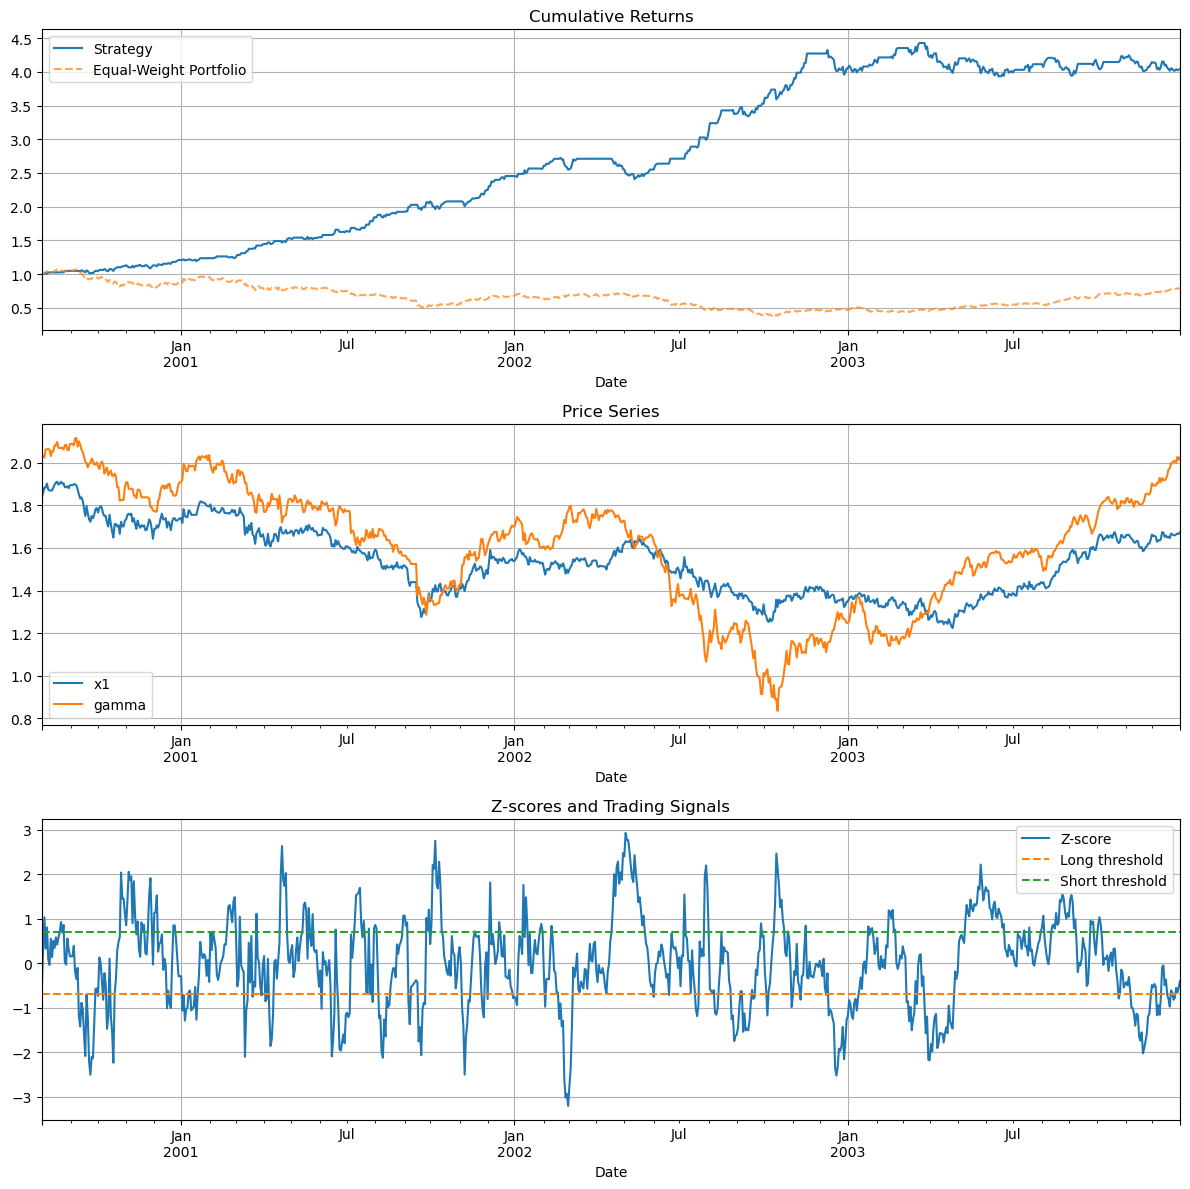

In [16]:
# Prepare data
prices = np.log(dfc).dropna()
Y = prices

# Estimate parameters using Kalman filter
mu, gamma = estimate_mu_gamma_kalman(Y)

# Run strategy
returns = pairs_trading(Y, gamma, mu, plot=True)


And we have properly implemented the methods in the paper.

## Excluding training window from strategy:

Initial parameters:
mu: 0.4431
gamma: 0.6780

Performance Comparison:
Strategy Total Return: 86.78%
Strategy Sharpe Ratio: 1.63
Benchmark Total Return: 17.63%
Benchmark Sharpe Ratio: 0.37


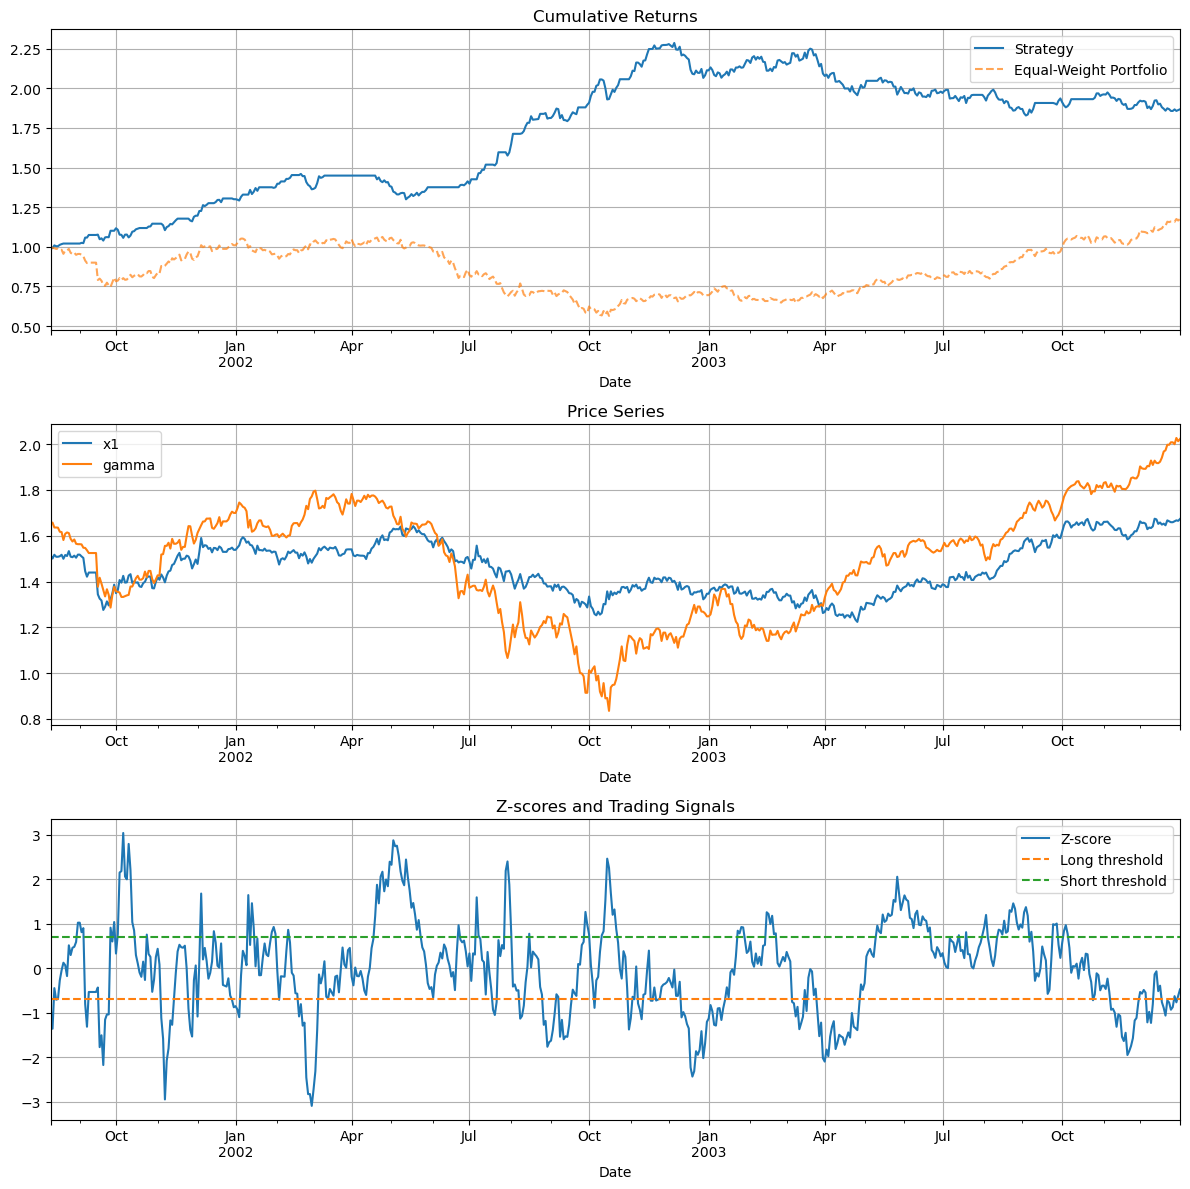

In [17]:
# Prepare data
prices = np.log(dfc).dropna()
Y = prices

# Estimate parameters using Kalman filter
mu, gamma = estimate_mu_gamma_kalman(Y, exclude_training=True)

# Run strategy
returns = pairs_trading(Y, gamma, mu, plot=True, exclude_training=True)


## OOS

[*********************100%***********************]  2 of 2 completed
/opt/miniconda3/envs/strat_testing/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Initial parameters:
mu: 0.9496
gamma: 0.3905

Performance Comparison:
Strategy Total Return: 98.00%
Strategy Sharpe Ratio: 0.69
Benchmark Total Return: -47.01%
Benchmark Sharpe Ratio: -0.07


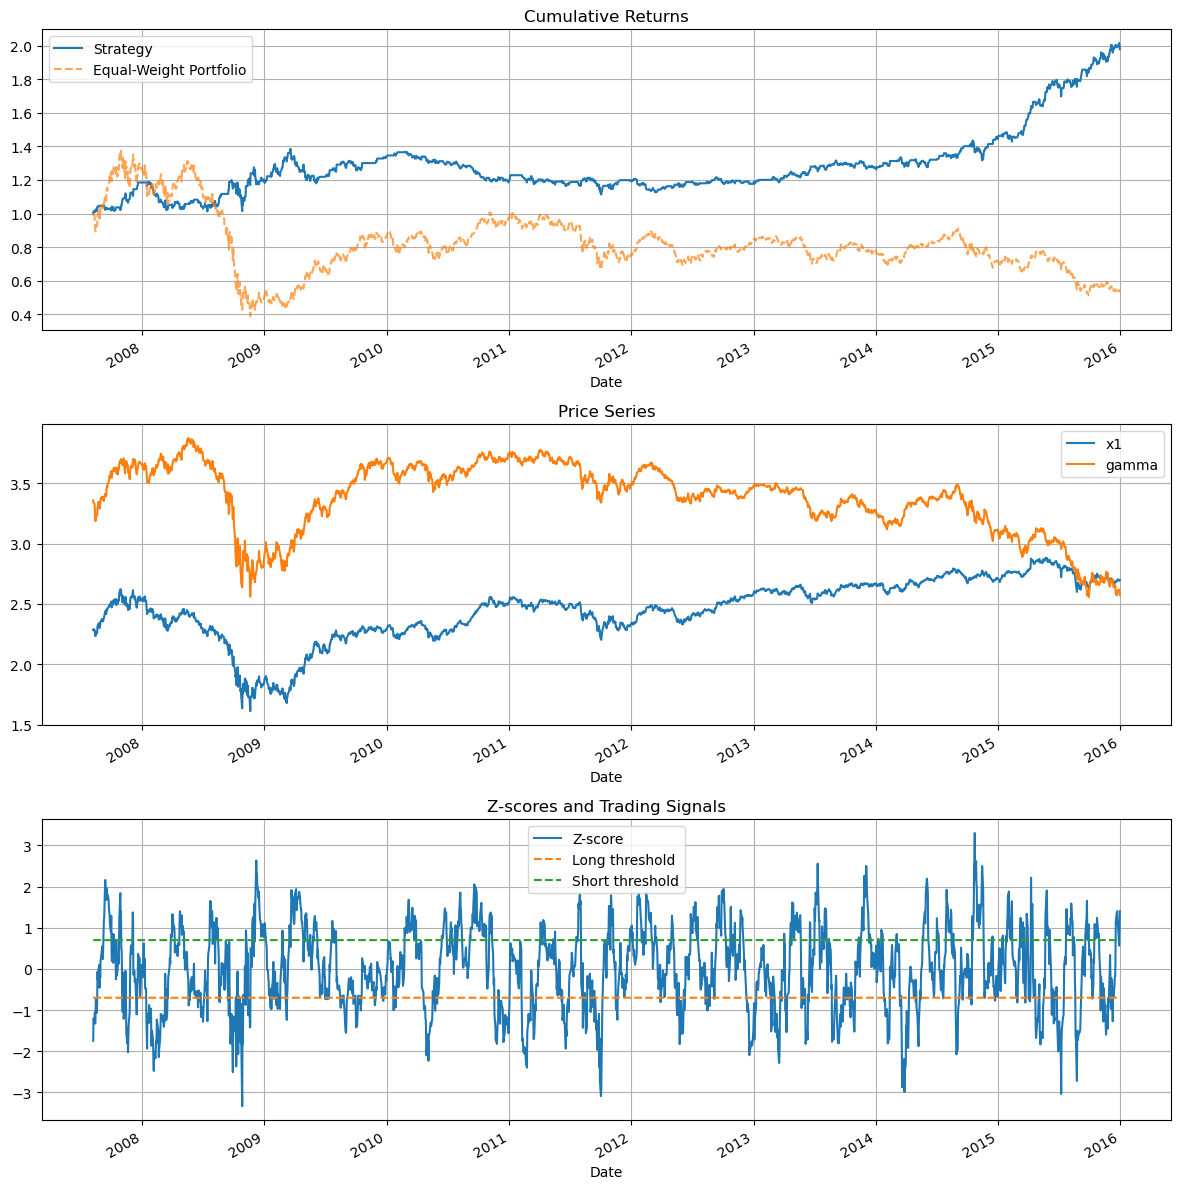

In [18]:
prices_OOS = yf.download(tickers, start='2004-01-01', end='2015-12-31', auto_adjust=True, multi_level_index=False).Close
# Prepare data
prices = np.log(prices_OOS).dropna()
Y = prices

# Estimate parameters using Kalman filter
mu, gamma = estimate_mu_gamma_kalman(Y, exclude_training=True)

# Run strategy
returns = pairs_trading(Y, gamma, mu, plot=True, exclude_training=True)


## Test on other data

In [19]:
spy_pair = ['SPY', 'QQQ']
ko_pair = ['KO', 'PEP']

spy_df = yf.download(spy_pair, start='2018-08-01', end='2022-1-1', auto_adjust=True, multi_level_index=False).Close
ko_df = yf.download(ko_pair, start='2018-08-01', end='2022-1-1', auto_adjust=True, multi_level_index=False).Close

spy_df.info()
ko_df.info()

[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 862 entries, 2018-08-01 to 2021-12-31
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   QQQ     862 non-null    float64
 1   SPY     862 non-null    float64
dtypes: float64(2)
memory usage: 20.2 KB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 862 entries, 2018-08-01 to 2021-12-31
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   KO      862 non-null    float64
 1   PEP     862 non-null    float64
dtypes: float64(2)
memory usage: 20.2 KB


/opt/miniconda3/envs/strat_testing/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Initial parameters:
mu: -1.7959
gamma: 1.2509

Performance Comparison:
Strategy Total Return: 3.36%
Strategy Sharpe Ratio: 0.33
Benchmark Total Return: 76.82%
Benchmark Sharpe Ratio: 1.09
Initial parameters:
mu: 1.0810
gamma: 0.5660


/opt/miniconda3/envs/strat_testing/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)



Performance Comparison:
Strategy Total Return: 12.83%
Strategy Sharpe Ratio: 0.59
Benchmark Total Return: 22.28%
Benchmark Sharpe Ratio: 0.47


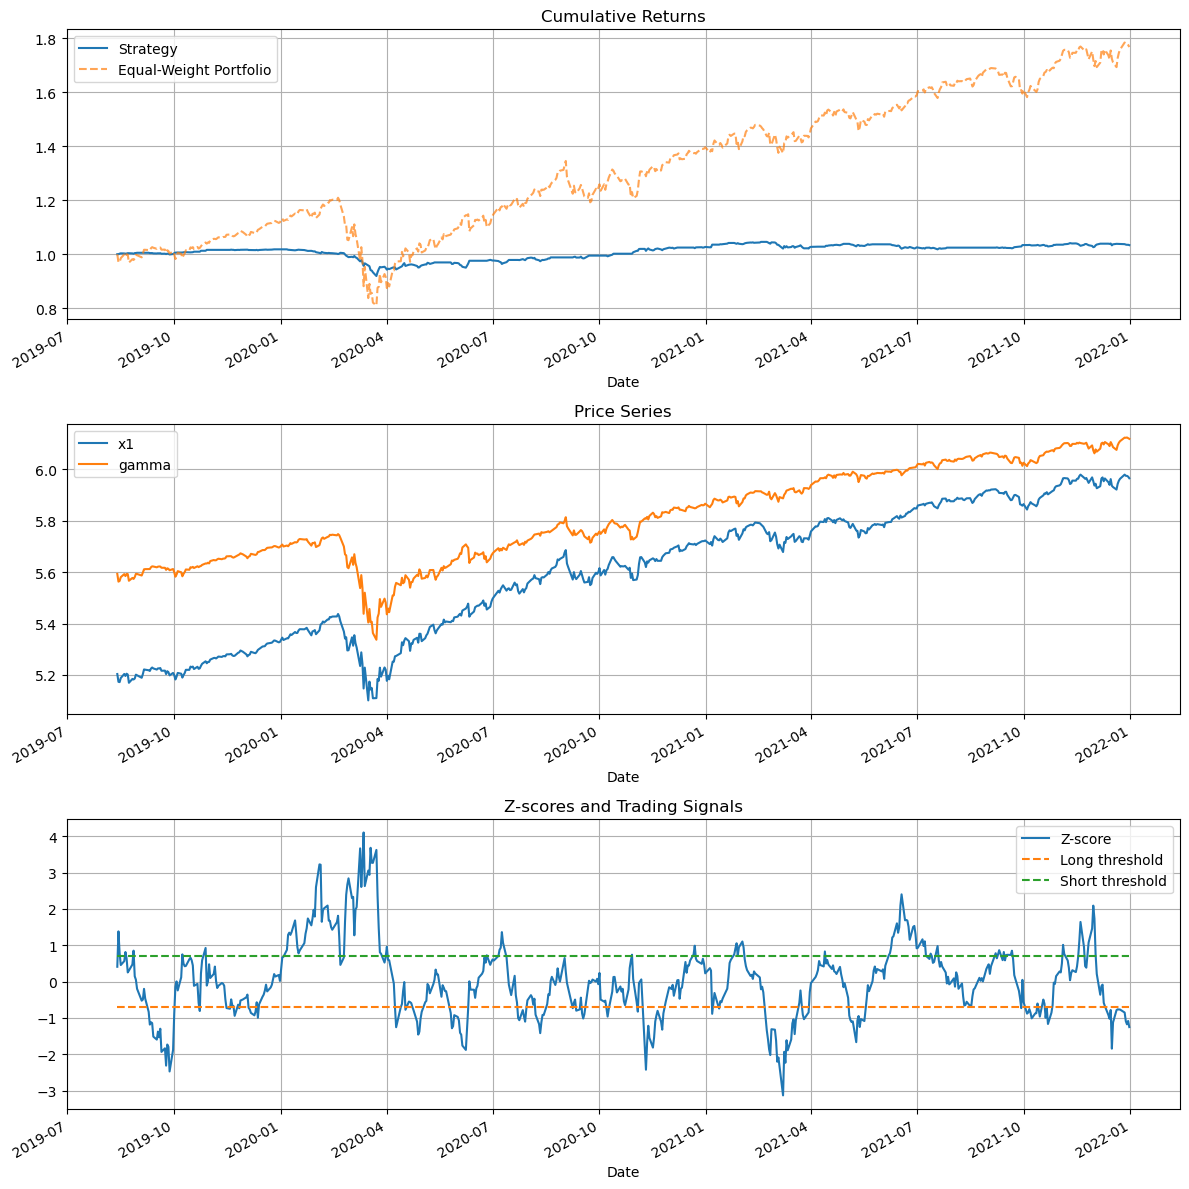

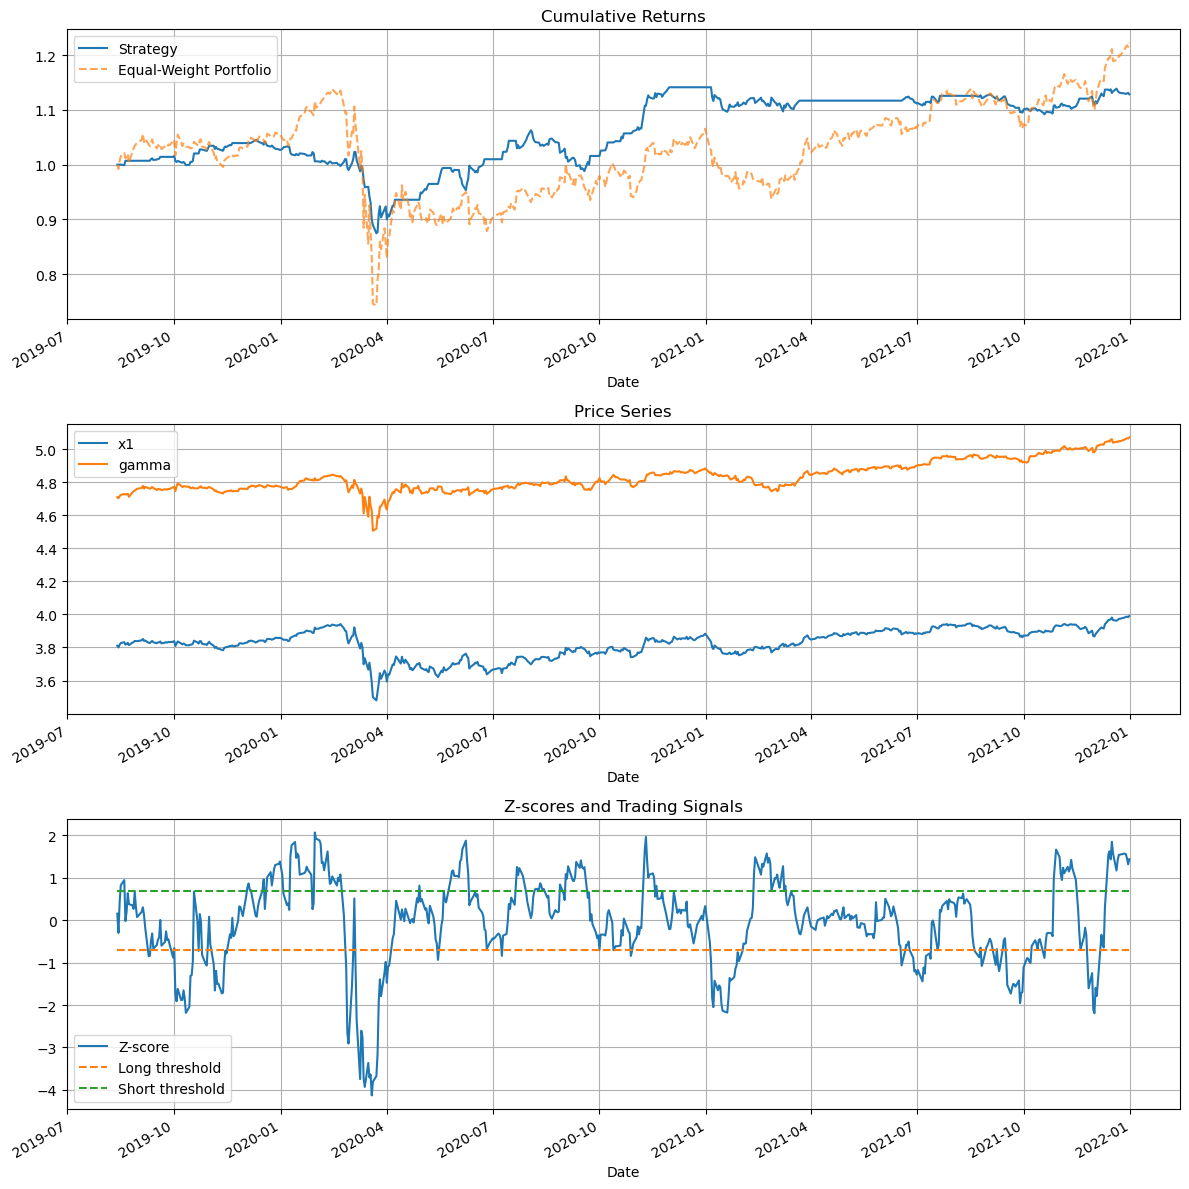

In [20]:
for data in [spy_df, ko_df]:
    # Prepare data
    prices = np.log(data).dropna()
    Y = prices

    # Estimate parameters using Kalman filter
    mu, gamma = estimate_mu_gamma_kalman(Y, exclude_training=True)

    # Run strategy
    returns = pairs_trading(Y, gamma, mu, plot=True, exclude_training=True)


## Without time-varying parameters OOS

[*********************100%***********************]  2 of 2 completed



Performance Comparison:
Strategy Total Return: -8.85%
Strategy Sharpe Ratio: -0.01
Benchmark Total Return: -47.01%
Benchmark Sharpe Ratio: -0.07


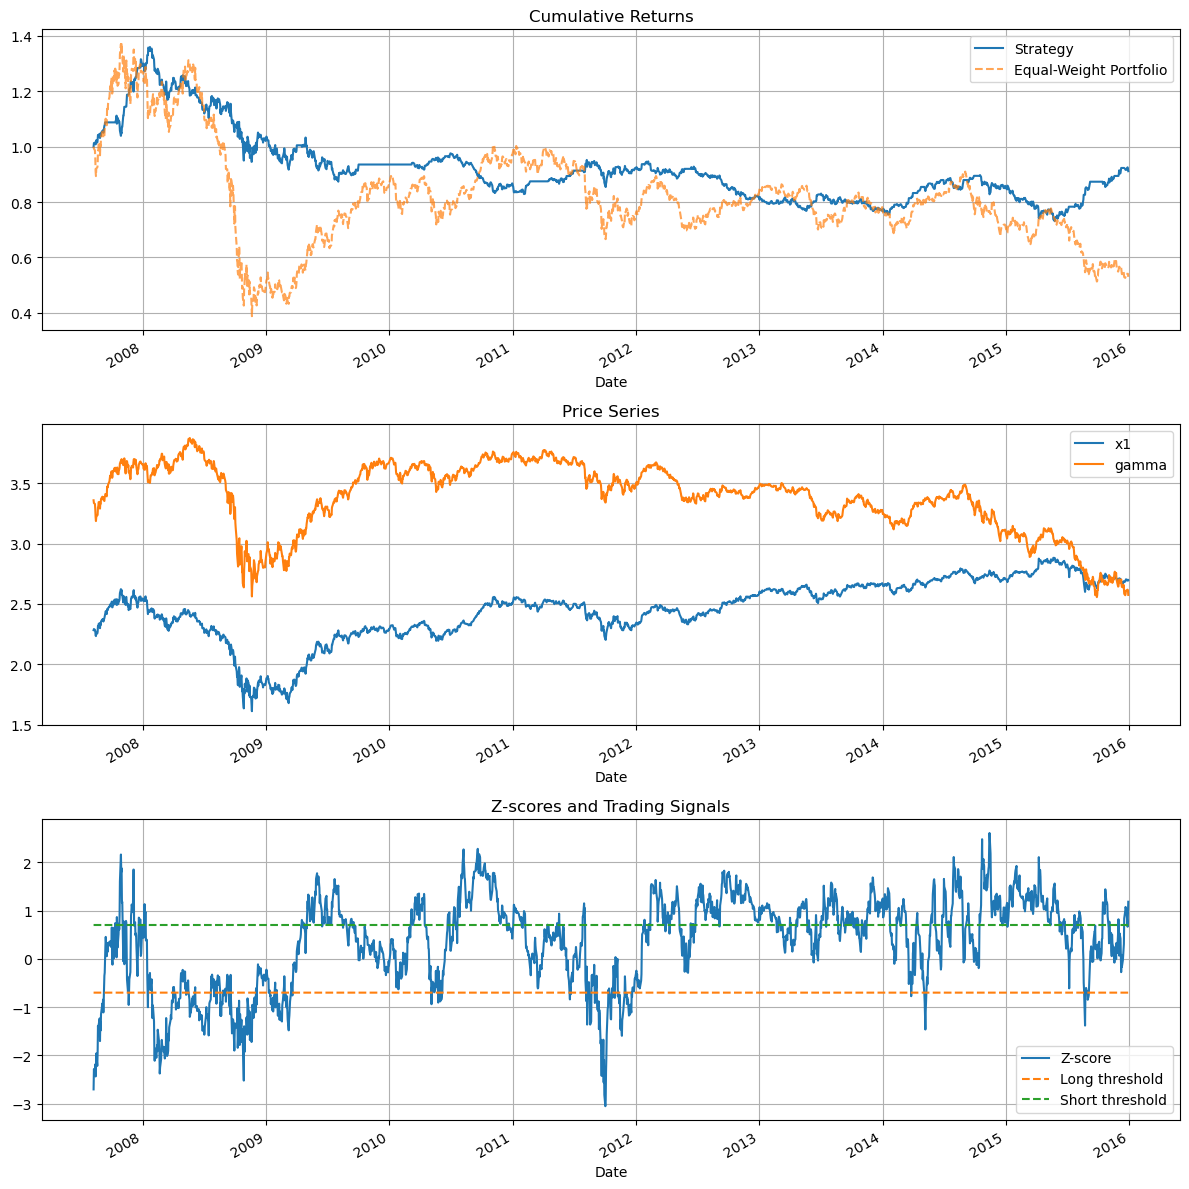

In [21]:
prices_OOS = yf.download(tickers, start='2004-01-01', end='2015-12-31', auto_adjust=True, multi_level_index=False).Close
# Prepare data
prices = np.log(prices_OOS).dropna()
Y = prices

# Estimate parameters using Kalman filter
mu, gamma = estimate_mu_gamma_LS(Y)

mu = pd.Series(mu, index=Y[math.ceil(0.3*len(Y)):].index)
gamma = pd.Series(gamma, index=Y[math.ceil(0.3*len(Y)):].index)

# Run strategy
returns = pairs_trading(Y, gamma, mu, plot=True, exclude_training=True)
